In [1]:
import numpy as np
import scipy
from qutip import *
from numba import jit, njit

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap

from mpl_toolkits.mplot3d import Axes3D
from plotly.offline import plot
import plotly.graph_objs as go

import sys

In [2]:
@njit
def adim_free_dyadic(vec_r1, vec_r2, k0):
    a0 = 60. + 1j*0. #space cutoff in nm
    r = k0*( vec_r1 - vec_r2 ) + 1j*0.
    r0 = np.sqrt(np.abs(np.dot(r,r)) ) + 1j*0.
    
    G = np.zeros( shape=(3,3), dtype=np.complex_ )

    r_k_r = ( np.outer(r,r) ) + 1j*0.
    if np.abs(r0) > .00001:

        G = np.exp( 1j*r0 )/(4*np.pi) * ( (1./r0 + 1./r0**2. - 1./r0**3.)*np.eye(3) + (3./r0**3. - 3.*1j/r0**2. - 1./r0)*r_k_r/r0**2.  ) * ( 1. - np.exp(-(np.abs(r0/k0/a0))**4.) )
    
    return G
@njit
def adim_half_space_dyadic(vec_r1, vec_r2, k0_ref, z0, img_active):
    img_A = 0
    if img_active == 1:
        img_A = 1
    
    reflectance = 1.
    
    k0 = k0_ref + 1j*k0_ref*.0
        
    r = k0*( vec_r1 - vec_r2 ) + 1j*0.
    r0 = np.sqrt(np.abs(np.dot(r,r)) ) + 1j*0.
    
    Mrinv = np.diag( np.array([1.+1j*0., 1.+1j*0., -1.+1j*0.]) )
    MZ = np.diag( np.array([0.+1j*0., 0.+1j*0., 1.+1j*0.]) )
    
    plane_pos = np.array([0.+1j*0., 0.+1j*0., z0+1j*0.])
    rI = k0*(vec_r1 - ( Mrinv @ (vec_r2+1j*0.) + 2.*plane_pos ) ) + 1j*0.
    rI0 = np.sqrt(np.abs(np.dot(rI,rI)) ) + 1j*0.
    
    r_k_r = ( np.outer(r,r) ) + 1j*0.
    rI_k_rI = ( np.outer(rI,rI) ) + 1j*0.
    
    G = np.zeros( shape=(3,3), dtype=np.complex_ )
    G0 = np.zeros( shape=(3,3), dtype=np.complex_ )
    GI = np.zeros( shape=(3,3), dtype=np.complex_ )
    if np.abs(r0) > .0001:
        Mn0 = - np.exp( 1j*r0 )/(4*np.pi) * ( np.eye(3)/r0**3. - 3.*r_k_r/r0**5. ) #* ( 1. - np.exp(-(np.abs(r0/k0/a0))**4.) )
        Mf0 = np.exp( 1j*r0 )/(4*np.pi)*( np.eye(3)*( 1./r0 + 1j/r0**2.) - r_k_r/r0**2.*( 1./r0 + 3*1j/r0**2.) )
        G0 = Mf0 + Mn0
    
    if np.abs(rI0) > .000001:   
        MnI = - np.exp( 1j*rI0 )/(4*np.pi) * ( np.eye(3)/rI0**3. - 3.*rI_k_rI/rI0**5. )
        MfI = np.exp( 1j*rI0 )/(4*np.pi)*( np.eye(3)*( 1./rI0 + 1j/rI0**2.) - rI_k_rI/rI0**2.*( 1./rI0 + 3*1j/rI0**2.) )
        GI = MfI + MnI #- 2.*MZ*np.exp( 1j*rI0 )/(4*np.pi)*( 1./rI0)
    G = G0 - img_A*reflectance * (GI @ Mrinv )
    
    return G

@njit
def system_dyadic_field_amplitude( R, D, k0, N_TLS, xvec, yvec, zvec, z0, img_active ):    
    arr_Ex = np.zeros(shape=(xvec.size*yvec.size*zvec.size, N_TLS), dtype=np.complex_)
    arr_Ey = np.zeros(shape=(xvec.size*yvec.size*zvec.size, N_TLS), dtype=np.complex_)
    arr_Ez = np.zeros(shape=(xvec.size*yvec.size*zvec.size, N_TLS), dtype=np.complex_)
    
    count = 0
    for nx in range(xvec.size):
        for ny in range(yvec.size):
            for nz in range(zvec.size):
                for n in range(N_TLS):
                    G = adim_half_space_dyadic( np.array([xvec[nx], yvec[ny], zvec[nz]]), R[n], k0, z0, img_active )
                    E = (G + 1j*0.) @ (D[n]+1j*0.)
                    arr_Ex[count][n] = E[0]
                    arr_Ey[count][n] = E[1]
                    arr_Ez[count][n] = E[2]
                count += 1

    return arr_Ex, arr_Ey, arr_Ez

@njit
def polar_system_dyadic_field_amplitude( R, D, k0, N_TLS, theta, phi, dist, z0, img_active ):    
    arr_Ex = np.zeros(shape=(theta.size*phi.size, N_TLS), dtype=np.complex_)
    arr_Ey = np.zeros(shape=(theta.size*phi.size, N_TLS), dtype=np.complex_)
    arr_Ez = np.zeros(shape=(theta.size*phi.size, N_TLS), dtype=np.complex_)
    
    count = 0
    for n2 in range(phi.size):
        for n1 in range(theta.size):
            for n in range(N_TLS):
                x = dist * np.sin(phi[n2]) * np.cos(theta[n1])
                y = dist * np.sin(phi[n2]) * np.sin(theta[n1])
                z = dist * np.cos(phi[n2])
                G = adim_half_space_dyadic( np.array([x, y, z]), R[n], k0, z0, img_active )
                E = (G + 1j*0.) @ (D[n]+1j*0.)
                arr_Ex[count][n] = E[0]
                arr_Ey[count][n] = E[1]
                arr_Ez[count][n] = E[2]
            count += 1

    return arr_Ex, arr_Ey, arr_Ez

@njit
def polar_system_dyadic_field_amplitude( R, D, k0, N_TLS, theta, phi, dist, z0, img_active ):    
    arr_Ex = np.zeros(shape=(theta.size*phi.size, N_TLS), dtype=np.complex_)
    arr_Ey = np.zeros(shape=(theta.size*phi.size, N_TLS), dtype=np.complex_)
    arr_Ez = np.zeros(shape=(theta.size*phi.size, N_TLS), dtype=np.complex_)
    
    count = 0
    for n2 in range(phi.size):
        for n1 in range(theta.size):
            for n in range(N_TLS):
                x = dist * np.sin(phi[n2]) * np.cos(theta[n1])
                y = dist * np.sin(phi[n2]) * np.sin(theta[n1])
                z = dist * np.cos(phi[n2])
                G = adim_half_space_dyadic( np.array([x, y, z]), R[n], k0, z0, img_active )
                E = (G + 1j*0.) @ (D[n]+1j*0.)
                arr_Ex[count][n] = E[0]
                arr_Ey[count][n] = E[1]
                arr_Ez[count][n] = E[2]
            count += 1

    return arr_Ex, arr_Ey, arr_Ez

@njit
def polar_matrix_system_dyadic_field_amplitude( R, D, k0, N_TLS, theta, phi, dist, z0, img_active ):    
    arr_Ex = np.zeros(shape=(theta.size, phi.size, N_TLS), dtype=np.complex_)
    arr_Ey = np.zeros(shape=(theta.size, phi.size, N_TLS), dtype=np.complex_)
    arr_Ez = np.zeros(shape=(theta.size, phi.size, N_TLS), dtype=np.complex_)
    
    for n2 in range(phi.size):
        for n1 in range(theta.size):
            for n in range(N_TLS):
                x = dist * np.sin(phi[n2]) * np.cos(theta[n1])
                y = dist * np.sin(phi[n2]) * np.sin(theta[n1])
                z = dist * np.cos(phi[n2])
                G = adim_half_space_dyadic( np.array([x, y, z]), R[n], k0, z0, img_active )
                E = (G + 1j*0.) @ (D[n]+1j*0.)
                arr_Ex[n1][n2][n] = E[0]
                arr_Ey[n1][n2][n] = E[1]
                arr_Ez[n1][n2][n] = E[2]

    return arr_Ex, arr_Ey, arr_Ez

@njit
def interaction_matrix(R, D, k0, N, z0, img_active):
    K = np.zeros( shape=(N,N), dtype=np.complex_  )
    for n1 in range(N):
        for n2 in range(N):
            G = adim_half_space_dyadic(R[n1], R[n2], k0, z0, img_active)
            K[n1][n2] = np.vdot( (D[n1]+1j*0.) , ( (G + 1j*0.) @ (D[n2] + 1j*0.) ) )

    return K


In [3]:
def spherical_distance(theta1, phi1, theta2, phi2):
    """
    Compute the great-circle distance between two points on the sphere.
    
    Parameters:
    - theta1, phi1: coordinates of the first point in radians.
    - theta2, phi2: coordinates of the second point in radians.
    
    Returns:
    - distance: the great-circle distance.
    """
    delta_theta = theta2 - theta1
    delta_phi = phi2 - phi1
    a = np.sin(delta_theta / 2)**2 + np.cos(theta1) * np.cos(theta2) * np.sin(delta_phi / 2)**2
    return 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

def create_spherical_kernel(size, theta0, phi0):
    """
    Create a spherical averaging kernel of a given size around a central point.
    
    Parameters:
    - size: int, the size of the kernel in each dimension.
    - theta0, phi0: coordinates of the central point in radians.
    
    Returns:
    - kernel: 2D numpy array, the spherical averaging kernel.
    """
    kernel = np.zeros((size, size))
    center = size // 2
    theta_range = np.linspace(theta0 - np.pi/size, theta0 + np.pi/size, size)
    phi_range = np.linspace(phi0 - 2*np.pi/size, phi0 + 2*np.pi/size, size)
    
    for i in range(size):
        for j in range(size):
            kernel[i, j] = spherical_distance(theta0, phi0, theta_range[i], phi_range[j])
    
    kernel = np.exp(-kernel**2 / (2 * (np.pi/size)**2))  # Gaussian-like weight based on distance
    kernel /= kernel.sum()  # Normalize the kernel
    return kernel

def create_averaging_kernel(size):
    """
    Create a normalized averaging kernel of a given size.
    
    Parameters:
    - size: int, the size of the kernel in each dimension.
    
    Returns:
    - kernel: 2D numpy array, the averaging kernel.
    """
    kernel = np.ones((size, size))
    kernel /= kernel.sum()
    return kernel

@njit
def solid_angle_averaging(I, Mprovv, theta, phi, limit_angle):
    #avgI = I.copy()*0
    for n2 in range(phi.size):
        for n1 in range(theta.size):
            theta0 = theta[n1]
            phi0 = phi[n2]
            X0 = np.array( [np.cos(theta0)*np.sin(phi0), np.sin(theta0)*np.sin(phi0), np.cos(phi0) ] )
            count = 0
            total_weight = 0
            for nph in range(phi.size):
                for nth in range(theta.size):
                    theta_n = theta[nth]
                    phi_n = phi[nph]
                    Xtp = np.array( [np.cos(theta_n)*np.sin(phi_n), np.sin(theta_n)*np.sin(phi_n), np.cos(phi_n) ] )
                    projection = np.dot(X0, Xtp)
                    if projection >= np.cos(limit_angle):
                        weight = np.sin(phi_n)
                        Mprovv[n1,n2,:,:] += I[nth,nph,:,:]*weight
                        total_weight += weight
                        count += 1
            if total_weight > 0:
                Mprovv[n1,n2,:,:] = Mprovv[n1,n2,:,:]/total_weight
            #if count > 0:
            #    Mprovv[n1,n2,:,:] = Mprovv[n1,n2,:,:]/count
    
    return Mprovv


def avg_solid_angle(I, Nn, theta, phi, kernel_size):
    # Define the averaging kernel (e.g., 3x3)
    #kernel_size = 4  # Size of the kernel
    #kernel = np.ones((kernel_size, kernel_size)) / (kernel_size * kernel_size)

    # Initialize the output tensor M_averaged with the same shape as M
    I_averaged = np.zeros_like(I)

    # Apply convolution along the first two dimensions for each (n, m) slice
    for n in range(Nn):
        for m in range(Nn):
            #kernel = create_spherical_kernel(kernel_size, phi[m], theta[n])
            kernel = create_averaging_kernel(kernel_size)
            I_averaged[:, :, n, m] = scipy.ndimage.convolve(I[:, :, n, m], kernel, mode='reflect')

    return I_averaged

In [4]:
def uniform_random_lattice(volume_bounds, L, N, max_attempts=10000):
    """
    Generate N points randomly within a specified volume ensuring minimum distance L between points.

    :param volume_bounds: A tuple of 6 elements defining the bounds (x_min, x_max, y_min, y_max, z_min, z_max).
    :param L: Minimum distance between points.
    :param N: Number of points to generate.
    :param max_attempts: Maximum number of attempts to generate each valid point.
    :return: A numpy array of points.
    """
    x_min, x_max, y_min, y_max, z_min, z_max = volume_bounds
    points = []

    def is_valid(point):
        """Check if the point is at least distance L away from all existing points."""
        for p in points:
            if np.linalg.norm(point - p) < L:
                return False
        return True

    while len(points) < N:
        attempts = 0
        while attempts < max_attempts:
            point = np.array([
                np.random.uniform(x_min, x_max),
                np.random.uniform(y_min, y_max),
                np.random.uniform(z_min, z_max)
            ])

            if is_valid(point):
                points.append(point)
                break
            else:
                attempts += 1

        if attempts >= max_attempts:
            print(f"Reached max attempts for a point. Generated {len(points)} points out of {N} requested.")
            break
    
    R = np.array(points)  
    N_TLS = R.shape[0]
    
    Rc = np.sum(R, axis=0)/N_TLS
    R[:,0] -= Rc[0]
    R[:,1] -= Rc[1]
    R[:,2] -= Rc[2]
    
    return R, N_TLS
def ordered_chain(L, N):
    R = np.zeros(shape=(N,3))
    for n in range(N):
        R[n][0] = n*L
    
    Rc = np.sum(R, axis=0)/N
    R[:,0] -= Rc[0]
    R[:,1] -= Rc[1]
    R[:,2] -= Rc[2]
    return R 

def triang_triangular_lattice( L, Nx, Ny ):
    N = Nx*Ny
    R = np.zeros(shape=(N,3))
    n=0
    for y in range(Ny):
        if y < Nx:
            for x in range(Nx-y):
                if y%2==0:
                    R[n][0] = x + .5*(y)
                    R[n][1] = y*(np.sqrt(3.)/2.)
                else:
                    R[n][0] = x + .5 + .5*(y-1)
                    R[n][1] = y*(np.sqrt(3.)/2.)
                n += 1
    M = n
    Rc = np.sum(R, axis=0)/M
    R[:,0] -= Rc[0]
    R[:,1] -= Rc[1]
    R[:,2] -= Rc[2]
    
    R_trimmed = R[:M].copy()

    return L*R_trimmed, int(M)

def all_ordered_dipole(N, direction):
    D = np.zeros(shape=(N,3))
    for n in range(N):
        D[n][direction] = 1
    return D   
def partially_random_dipoles(N, direction, sigma_rel):
    D = np.zeros(shape=(N,3))
    sigma = np.pi * sigma_rel
    for n in range(N):
        if direction == 0:
            angle_1 = sigma*np.random.normal(0.0, 1.0)
            angle_2 = np.pi/2. + sigma*np.random.normal(0.0, 1.0)
        elif direction == 1:
            angle_1 = np.pi/2. + sigma*np.random.normal(0.0, 1.0)
            angle_2 = np.pi/2. + sigma*np.random.normal(0.0, 1.0)
        elif direction == 2:
            angle_1 = sigma*np.random.normal(0, 1.0)
            angle_2 = sigma*np.random.normal(0, 1.0)    
        D[n][0] = np.cos( angle_1 )*np.sin(angle_2)
        D[n][1] = np.sin( angle_1 )*np.sin(angle_2)
        D[n][2] = np.cos(angle_2)
        
    return D


def plot_points_with_vectors(points, vectors, l0, freq):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # Create a custom colormap
    colors = [(0, 0, 1), (0, 0, 0), (1, 0, 0)]  # Blue -> Black -> Red
    cmap_name = 'blue_black_red'
    cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=256)
    #cmap = cm.coolwarm

    
    # Normalize the frequency array to the range [0, 1] for colormap
    norm = plt.Normalize(freq.min(), freq.max())


    sc = ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=freq, cmap=cm, marker='o', norm=norm)
    xmax = np.amax(points[:, 0])
    xmin = np.amin(points[:, 0])
    if xmax-xmin <= l0:
        xmax = l0
        xmin = -l0
    ymax = np.amax(points[:, 1])
    ymin = np.amin(points[:, 1])
    if ymax-ymin <= l0:
        ymax = l0
        ymin = -l0
    zmax = np.amax(points[:, 2])
    zmin = np.amin(points[:, 2])
    if zmax-zmin <= l0:
        zmax = l0
        zmin = -l0
    Lmax = np.amax( np.array([xmax,ymax,zmax]) )
    Lmin = np.amin( np.array([xmin,ymin,zmin]) )
    ax.set_xlim(Lmin, Lmax)
    ax.set_ylim(Lmin, Lmax)
    ax.set_zlim(Lmin, Lmax)

    # Plot vectors as arrows
    for point, vector in zip(points, vectors):
        ax.quiver(point[0], point[1], point[2], vector[0], vector[1], vector[2], length=l0/2., normalize=True)

    ax.set_xlabel('X - nm')
    ax.set_ylabel('Y - nm')
    ax.set_zlabel('Z - nm')
    # Add color bar to indicate the frequency values
    cbar = plt.colorbar(sc, ax=ax)
    cbar.set_label('Frequency - GHz')


    plt.title(f'Positions of the {len(points)}-TLS with relative frequency and dipole direction')
    plt.show()  
def plot_points_with_vectors_browser(points, vectors, l0):
    trace_points = go.Scatter3d(
        x=points[:, 0],
        y=points[:, 1],
        z=points[:, 2],
        mode='markers',
        marker=dict(size=2, color='blue'),
        name='Points'
    )

    traces = [trace_points]

    for point, vector in zip(points, vectors):
        trace_vector = go.Cone(
            x=[point[0]],
            y=[point[1]],
            z=[point[2]],
            u=[l0*vector[0]],
            v=[l0*vector[1]],
            w=[l0*vector[2]],
            sizemode='scaled',
            sizeref=0.1,
            anchor='tail',
            colorscale='Blues',
            showscale=False
        )
        traces.append(trace_vector)

    layout = go.Layout(
        title='3D Scatter Plot of Points with Vectors',
        scene=dict(
            xaxis_title='X Axis',
            yaxis_title='Y Axis',
            zaxis_title='Z Axis'
        )
    )

    fig = go.Figure(data=traces, layout=layout)
    plot(fig)    
    
    
def plot_points_with_vectors_substrate(points, vectors, l0, freq, z0):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # Create a custom colormap
    colors = [(0, 0, 1), (0, 0, 0), (1, 0, 0)]  # Blue -> Black -> Red
    cmap_name = 'blue_black_red'
    cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=256)
    
    # Normalize the frequency array to the range [0, 1] for colormap
    norm = plt.Normalize(freq.min(), freq.max())

    # Scatter plot for points
    sc = ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=freq, cmap=cm, marker='o', norm=norm)
    
    # Determine the plot limits
    xmax, xmin = np.max(points[:, 0]), np.min(points[:, 0])
    ymax, ymin = np.max(points[:, 1]), np.min(points[:, 1])
    zmax, zmin = np.max(points[:, 2]), np.min(points[:, 2]) 
    
    if xmax - xmin <= l0:
        xmax, xmin = l0, -l0
    if ymax - ymin <= l0:
        ymax, ymin = l0, -l0
    if zmax - zmin <= l0:
        zmax, zmin = l0, -l0
        
    Lmax = np.max([xmax, ymax])
    Lmin = np.min([xmin, ymin])
    ax.set_xlim(Lmin, Lmax)
    ax.set_ylim(Lmin, Lmax)
    ax.set_zlim(zmin + z0, zmax)

    # Plot vectors as arrows
    for point, vector in zip(points, vectors):
        ax.quiver(point[0], point[1], point[2], vector[0], vector[1], vector[2], length=l0 / 2., normalize=True)
    
    if np.abs(z0) < 5*Lmax:
        # Add a flat black surface at z = z0
        x_surf = np.linspace(Lmin, Lmax, 100)
        y_surf = np.linspace(Lmin, Lmax, 100)
        x_surf, y_surf = np.meshgrid(x_surf, y_surf)
        z_surf = np.full_like(x_surf, z0)
        ax.plot_surface(x_surf, y_surf, z_surf, color='yellow', alpha=0.5)  
    else:
        Lmax = np.max([xmax, ymax, zmax])
        Lmin = np.min([xmin, ymin, zmin])
        ax.set_xlim(Lmin, Lmax)
        ax.set_ylim(Lmin, Lmax)
        ax.set_zlim(Lmin, Lmax)

    ax.set_xlabel('X - nm')
    ax.set_ylabel('Y - nm')
    ax.set_zlabel('Z - nm')
    
    # Add color bar to indicate the frequency values
    cbar = plt.colorbar(sc, ax=ax)
    cbar.set_label('Frequency - GHz')

    plt.title(f'Positions of the {len(points)}-TLS with relative frequency and dipole direction')
    plt.show()    

In [5]:
def spin_operators(N):
    arr_sx = []
    arr_sy = []
    arr_sz = []
    arr_s_ = []
    for n in range(N):
        if n == 0:
            sx_n = 0.5*sigmax() 
            sy_n = 0.5*sigmay() 
            sz_n = 0.5*sigmaz() 
        elif n > 0:
            sx_n = qeye(2)
            sy_n = qeye(2)
            sz_n = qeye(2) 
            
        for m in range(1,n):
            sx_n = tensor( sx_n, qeye(2) )
            sy_n = tensor( sy_n, qeye(2) )
            sz_n = tensor( sz_n, qeye(2) )
        
        if n > 0 :
            sx_n = tensor(sx_n, 0.5*sigmax())
            sy_n = tensor(sy_n, 0.5*sigmay())
            sz_n = tensor(sz_n, 0.5*sigmaz()) 

        for m in range(N-n-1):
            sx_n = tensor( sx_n, qeye(2) )
            sy_n = tensor( sy_n, qeye(2) )
            sz_n = tensor( sz_n, qeye(2) )

        arr_sx.append(sx_n)
        arr_sy.append(sy_n)
        arr_sz.append(sz_n)
        arr_s_.append(sx_n-1j*sy_n)

    return arr_sx, arr_sy, arr_sz, arr_s_

In [114]:
Nx = 2
Ny = 1
N_TLS = Nx*Ny


#arr_l0 = np.linspace(50,3000,20)
l0 = 2000
arr_thetaNA = np.linspace(1./100., 1./4., 50) * np.pi
#theta_NA = np.pi/30

arr_g2 = []
arr_g2sr = []
arr_g2sub = []
arr_g3 = []

#for nl0, l0 in enumerate(arr_l0):
for nNA, theta_NA  in enumerate(arr_thetaNA):

    #R = ordered_chain(l0, N_TLS)
    R, N_TLS = triang_triangular_lattice( l0, Nx, Ny )



    lam0 = 785 # laser wavelength in nm
    k0 = 2*np.pi/lam0       # for the dyadic one should in principle use k including the detuning. But 1Ghz of detuning is 10^-7 in k, completely irrelevant
                                        # total volume of the nanocrystal in nm
    Lx = 100
    Ly = 100
    Lz = 100

    sx, sy, sz, s_ = spin_operators(N_TLS)

                                        #reference electric field at lambda0 with d = 13 D
    Edd_ref = 0.0248 # kV/cm
                                        #include a golden substrate
    img_active = 1  #choose to use free space '==0' or half space '==1' dyadic Green function
    z0 = - 100     #position in nm of the conductinc plate (only if img_active == 1)

                                        # in GHz - detuning of the molecules with respect external pump, molecules losses, dipole-dipole reference scale
    gamma = .05  # homogeneous broadening, or Fourier limit linewidth
    gamma_deph = 1. # pure dephasing rate (to be done properly I should include the detuning dependence that takes account of the phonons spectral density)
    Udd = 1.    # coefficiente dimensionale dyadic in GHz -> Udd = e^2/epsilon0 k0^3 xi_d^2 ( e xi_d = dipole transition \approx 13 D )
    Gamma0 = Udd/(3.*np.pi)     # ==== Single emitter diagonal spontaneous decay rate of the free space dyadic. Necessary to ensure stability.

    OmR = 0.
    sigma_freqs = 0.
                                        #arr_freq_dis = sigma_freqs*np.random.normal(0.0, 1., size=N_TLS) #array that stores fluctuations of TLS freqs., sigma is in GHz
    arr_freq_dis = sigma_freqs*np.random.uniform(-1./2., 1./2., size=N_TLS)

                                        #detuning with respect external laser
    det0 = 0. #* np.sqrt(N_TLS)        #in Ghz

    Gam_p = 1.                           #Incoherent pump strength

                                        #select orientation dipoles
    direction_dipole = 1    # x==0, y==1, z==2

                                        #define dipole moment axis of each TLS
    D = partially_random_dipoles(N_TLS, direction_dipole, 0.0)

    #plot_points_with_vectors_substrate(R, D, 20., arr_freq_dis, z0)

    Edrive = np.array([0, 0, 0])
    Edrive[direction_dipole] = 1
    projE = np.matmul( D, Edrive )
    dir_k = np.array([0, 0, 1])
    if direction_dipole == 2 or direction_dipole == 1 :
        dir_k = np.array([1, 0, 0])

    K = np.zeros(shape=(N_TLS, N_TLS), dtype=np.complex_)
    K = interaction_matrix(R, D, k0, N_TLS, z0, img_active)

    Gamma_tens = 2.*Udd*K.imag + (gamma + Gamma0)*np.eye( N_TLS )
    ikvals, ikvecs = np.linalg.eig(Gamma_tens)
    idx = np.argsort(ikvals)
    ikvals = ikvals[idx]
    ikvecs = ikvecs[:,idx]

    dressed_jump = []
    for nik in range(ikvals.size):
        for ntls in range(N_TLS):
            Gk = ikvals[nik]
            if Gk < 0:
                Gk = 0.
                print("diocanissimo")
            dressed_jump.append( np.sqrt( ( Gk + 1j*0.0 ) ) * ikvecs[ntls,nik] * s_[ntls] )

    Heff = 0*sz[0] 
    arr_cjump = []
    Ltot = 0*lindblad_dissipator( s_[0] )
    for n1 in range(N_TLS):
        Heff += ( det0 + arr_freq_dis[n1] ) * s_[n1].dag()*s_[n1] + .5*OmR * projE[n1] * (s_[n1]*np.exp(-1j*k0*np.dot(dir_k, R[n1]) ) + s_[n1].dag()*np.exp(+1j*k0*np.dot(dir_k, R[n1]) ) )
        arr_cjump.append( np.sqrt(Gam_p)*s_[n1].dag()  )
        arr_cjump.append( np.sqrt(gamma_deph)*s_[n1].dag()*s_[n1] )
        for n2 in range(N_TLS):
            Heff += - 1.*Udd*K[n1][n2].real * s_[n1].dag()*s_[n2]
    arr_jump_tot = arr_cjump + dressed_jump
    Ltot += liouvillian(Heff, arr_jump_tot)

    rho_ss = steadystate(Ltot)
    
    
    
    
    dist = lam0*30.
    theta = np.linspace( 0., 2.*np.pi, 100)
    phi = np.linspace(0, np.pi/2., 100)
    polar_Ex, polar_Ey, polar_Ez = polar_matrix_system_dyadic_field_amplitude( R, D, k0, N_TLS, theta, phi, dist, z0, img_active )

    @njit
    def polar_intensity_matrix(matE, Ni, Nj, Nn, M):
        for i in range(Ni):
            for j in range(Nj):
                for n in range(Nn):
                    for m in range(Nn):
                        M[i][j][n][m] = np.conj(matE[i][j][n]) * matE[i][j][m]
        return M
    # Get the shape of E
    Ni, Nj, Nn = polar_Ex.shape
    # Initialize the output tensor M_ijnm
    Mxx = np.zeros((Ni, Nj, Nn, Nn), dtype=complex)
    Myy = np.zeros((Ni, Nj, Nn, Nn), dtype=complex)
    Mzz = np.zeros((Ni, Nj, Nn, Nn), dtype=complex)
    Ixx = polar_intensity_matrix(polar_Ex, Ni, Nj, Nn, Mxx)
    Iyy = polar_intensity_matrix(polar_Ey, Ni, Nj, Nn, Myy)
    Izz = polar_intensity_matrix(polar_Ez, Ni, Nj, Nn, Mzz)

    I = Ixx + Iyy + Izz

    I[1:theta.size,0,:,:] = I[1:theta.size,0,:,:].copy()*0 #remove the Ntheta-copies of the north-pole
    Mprovv = np.zeros((Ni, Nj, Nn, Nn), dtype=complex)

    I_avg = solid_angle_averaging(I, Mprovv, theta, phi, theta_NA)
    
    
    M_detect = I_avg[0,0,:,:]
    m_vals, m_vecs = np.linalg.eig(M_detect)
    idx = np.argsort(m_vals)
    m_vals = m_vals[idx]
    m_vecs = m_vecs[:,idx]
    
    for n in range(len(m_vals)):
        sys.stdout.write("(%.4f, %.4f) " % ( m_vals[n].real/np.amax(np.abs(m_vals)), m_vals[n].imag/np.amax(np.abs(m_vals)) ))
    sys.stdout.write("\n\r")
    sys.stdout.flush()

    f_ = []
    for k, ek in enumerate(m_vals):
        f_op = s_[0]*0
        for n in range(len(m_vals)):
            f_op += s_[n] * np.conj(m_vecs[n,k]) * np.sqrt( ek/np.amax(np.abs(m_vals)) )
        f_.append(f_op)
       
    fsr_op = s_[0]*0
    for n in range(N_TLS):
        fsr_op += s_[n]/np.sqrt(N_TLS)
    fsub_op = (s_[0] - s_[1])/2**.5    
        
    C2 = 0
    C3 = 0
    N1 = 0
    Nsr = 0
    Nsub = 0
    Csr = 0
    Csub = 0
    Nsr = expect( fsr_op.dag()*fsr_op, rho_ss)
    Nsub = expect( fsub_op.dag()*fsub_op, rho_ss)
    for k1 in range(len(m_vals)):
        N1 += expect( f_[k1].dag()*f_[k1], rho_ss)
        for k2 in range(len(m_vals)):
            
            C2 += expect( f_[k1].dag()*f_[k2].dag()*f_[k2]*f_[k1], rho_ss )
            Csr += expect( f_[k1].dag()*fsr_op.dag()*fsr_op*f_[k1], rho_ss )
            Csub += expect( f_[k1].dag()*fsub_op.dag()*fsub_op*f_[k1], rho_ss )
            
            for k3 in range(len(m_vals)):
                C3 += expect( f_[k3].dag()*f_[k1].dag()*f_[k2].dag() * f_[k2]*f_[k1]*f_[k3], rho_ss )
    g2 = C2 / N1**2
    g2sr = Csr / (Nsr * N1)
    g2sub = Csub / (Nsub * N1)
    g3 = C3 / N1**3
    
    arr_g2.append(g2)
    arr_g2sr.append(g2sr)
    arr_g2sub.append(g2sub)
    arr_g3.append(g3)
    
    
    sys.stdout.write("Completed = %.1f %% \r" % (100*nNA/len(arr_thetaNA)))
    #sys.stdout.write("Completed = %.1f %% \r" % (100*nl0/len(arr_l0)))
    sys.stdout.flush()
    

arr_g2 = np.asarray(arr_g2)
arr_g2sr = np.asarray(arr_g2sr)
arr_g2sub = np.asarray(arr_g2sub)
arr_g3 = np.asarray(arr_g3)
    



(0.0081, 0.0000) (1.0000, -0.0000) 
(0.0244, -0.0000) (1.0000, 0.0000) 
(0.0492, -0.0000) (1.0000, 0.0000) 
(0.0827, -0.0000) (1.0000, 0.0000) 
(0.1255, 0.0000) (1.0000, -0.0000) 
(0.1780, 0.0000) (1.0000, -0.0000) 
(0.2405, 0.0000) (1.0000, 0.0000) 
(0.3134, -0.0000) (1.0000, 0.0000) 
(0.3968, -0.0000) (1.0000, 0.0000) 
(0.4902, -0.0000) (1.0000, -0.0000) 
(0.5925, 0.0000) (1.0000, 0.0000) 
(0.7017, -0.0000) (1.0000, 0.0000) 
(0.8148, 0.0000) (1.0000, 0.0000) 
(0.9275, -0.0000) (1.0000, 0.0000) 
(0.9654, -0.0000) (1.0000, -0.0000) 
(0.8837, 0.0000) (1.0000, 0.0000) 
(0.8256, -0.0000) (1.0000, 0.0000) 
(0.7874, 0.0000) (1.0000, -0.0000) 
(0.7658, -0.0000) (1.0000, 0.0000) 
(0.7586, -0.0000) (1.0000, 0.0000) 
(0.7636, 0.0000) (1.0000, -0.0000) 
(0.7790, 0.0000) (1.0000, 0.0000) 
(0.8032, 0.0000) (1.0000, 0.0000) 
(0.8345, -0.0000) (1.0000, 0.0000) 
(0.8712, -0.0000) (1.0000, -0.0000) 
(0.9114, -0.0000) (1.0000, -0.0000) 
(0.9532, -0.0000) (1.0000, 0.0000) 
(0.9934, -0.0000) (1.0000, 0.0

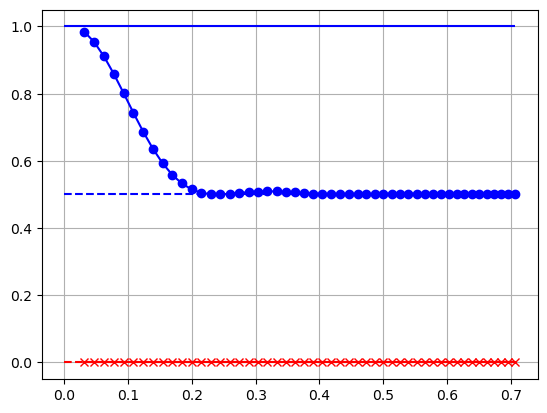

In [115]:
plt.plot(np.sin(arr_thetaNA), arr_g2, marker='o', color='blue')
plt.plot(np.sin(arr_thetaNA), arr_g3, marker='x', color='red')
plt.hlines(2*(N_TLS-1)/N_TLS, xmin=0, xmax=np.amax(np.sin(arr_thetaNA)), color='blue')
plt.hlines( 1-1/N_TLS, xmin=0, xmax=np.amax(np.sin(arr_thetaNA)), color='blue', linestyle='--')
plt.hlines( (N_TLS*(N_TLS-1)*(N_TLS-2))/N_TLS**3, xmin=0, xmax=np.amax(np.sin(arr_thetaNA)), color='red', linestyle='--')

#plt.hlines(10/3, xmin=0, xmax=np.amax(arr_l0), color='red')

plt.grid()

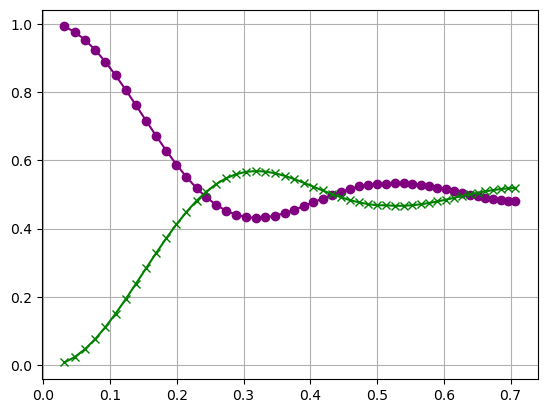

In [116]:
plt.plot(np.sin(arr_thetaNA), arr_g2sr/2, marker='o', color='purple')
plt.plot(np.sin(arr_thetaNA), arr_g2sub/2, marker='x', color='green')

plt.grid()

In [127]:
Gam_l = 1
Gam_p = 4.
gamma_deph = 0.
N_TLS = 3
sx, sy, sz, s_ = spin_operators(N_TLS)

arr_cjump = []
for n1 in range(N_TLS):
    Heff = 0 * s_[n1].dag()*s_[n1]
    arr_cjump.append( np.sqrt(Gam_p)*s_[n1].dag()  )
    arr_cjump.append( np.sqrt(Gam_l)*s_[n1]  )
    arr_cjump.append( np.sqrt(gamma_deph)*s_[n1].dag()*s_[n1] )
arr_jump_tot = arr_cjump
Ltot = liouvillian(Heff, arr_jump_tot)

rho_ss = steadystate(Ltot)

In [135]:
arr_g3 = []

arr_t = 2*np.pi * np.linspace(0.001,.999, 500)
x = 1.

for theta in arr_t:

    M = np.zeros((3,3), dtype=np.complex_)
    M += np.eye(3)
    
    M[0][0] = .999999
    M[1][1] = 1
    M[2][2] = 1.00001

    M[0][1] = np.sinc(x)*np.exp(1j*2*theta)
    M[0][2] = np.sinc(x)

    M[1][0] = np.sinc(x)*np.exp(-1j*2*theta)
    M[1][2] = np.sinc(x)

    M[2][0] = np.sinc(x)
    M[2][1] = np.sinc(x)

    m_vals, m_vecs = np.linalg.eig(M)
    idx = np.argsort(m_vals)
    m_vals = m_vals[idx]
    m_vecs = m_vecs[:,idx]

    f_ = []
    for k, ek in enumerate(m_vals):
        f_op = s_[0]*0
        for n in range(len(m_vals)):
            f_op += s_[n] * np.conj(m_vecs[n,k]) * np.sqrt( ek )
        f_.append(f_op)
    N1 = 0
    C3 = 0
    for k1 in range(len(m_vals)):
            N1 += expect( f_[k1].dag()*f_[k1], rho_ss)
            for k2 in range(len(m_vals)):            
                for k3 in range(len(m_vals)):
                    C3 += expect( f_[k3].dag()*f_[k1].dag()*f_[k2].dag() * f_[k2]*f_[k1]*f_[k3], rho_ss )
    g3 = C3 / N1**3
    arr_g3.append(g3)


arr_g3 = np.asarray(arr_g3)



In [138]:
np.sin(.1)

0.09983341664682815

(0.0, 2.0)

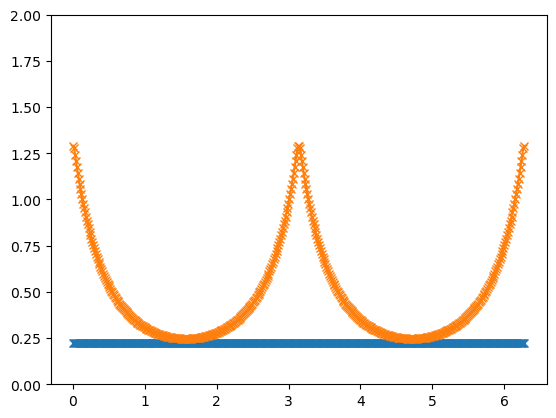

In [136]:
plt.plot(arr_t, arr_g3.real, marker='x')
plt.plot(arr_t, arr_g3_0.real, marker='x')

plt.ylim(0,2)

In [134]:
arr_g3_0 = arr_g3

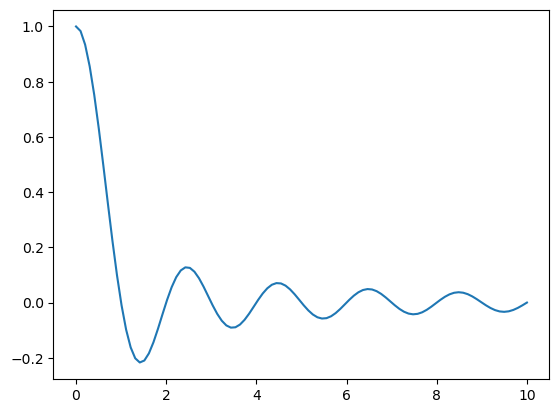

In [130]:
plt.plot(np.linspace(0,10,100), np.sinc(np.linspace(0,10,100)))